# Import Modules

In [1]:
import PIL
from PIL import Image
import numpy as np
import pandas as pd
from PIL import ImageEnhance
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from mlflow.models.signature import infer_signature
import tensorflow as tf
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import json
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import mlflow
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import mlflow
import matplotlib.pyplot as plt
import PIL
from PIL import Image

StatementMeta(, 4c726f5e-5abc-4204-88f5-f67b8b3bc843, 3, Finished, Available)

2024-06-06 12:37:19.271529: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-06 12:37:25.887089: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Preprocessing to resize images

Alter the data filepath and image filepath to run

StatementMeta(, 4c726f5e-5abc-4204-88f5-f67b8b3bc843, 4, Finished, Available)

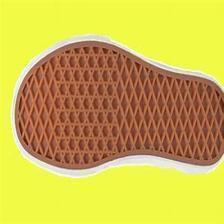

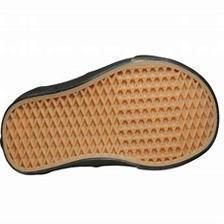

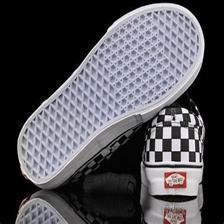

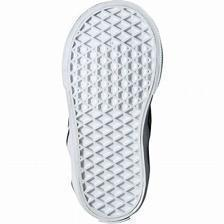

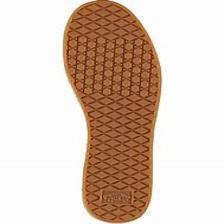

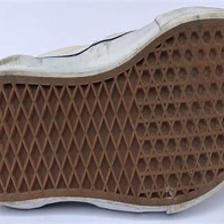

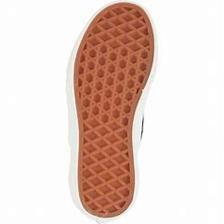

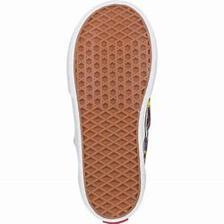

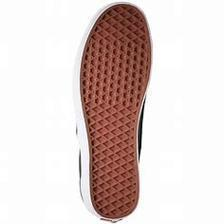

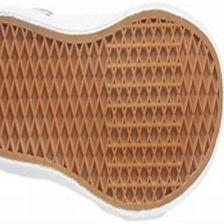

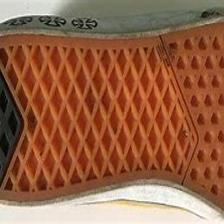

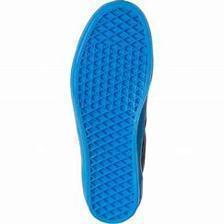

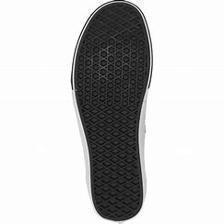

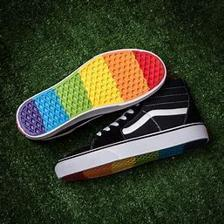

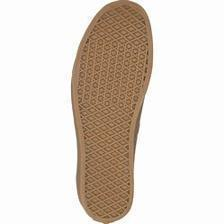

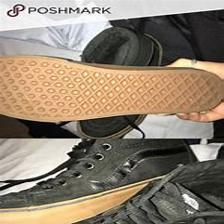

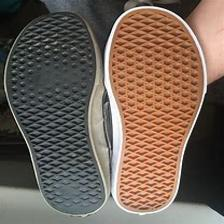

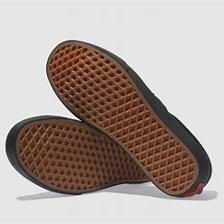

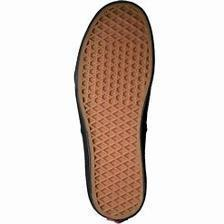

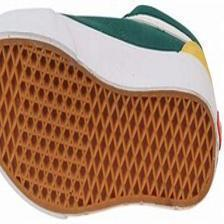

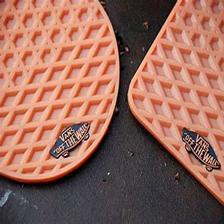

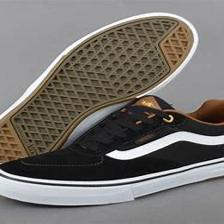

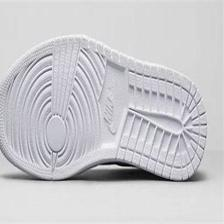

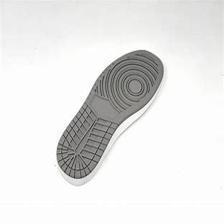

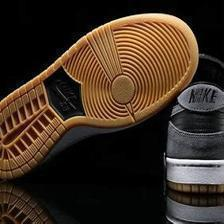

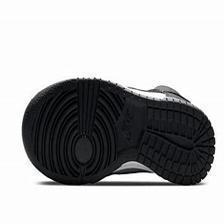

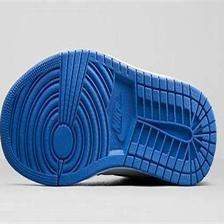

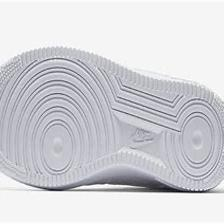

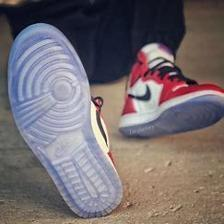

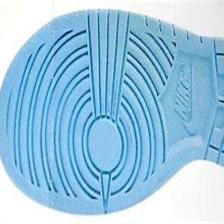

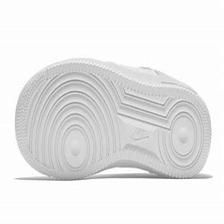

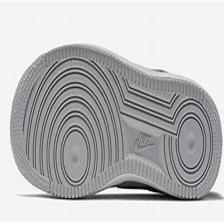

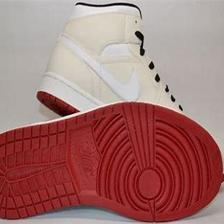

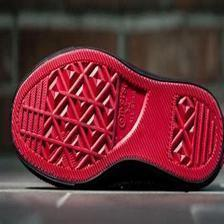

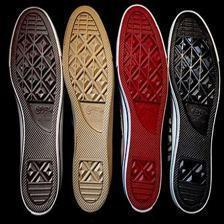

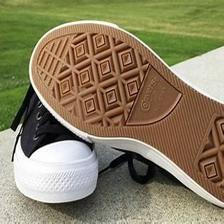

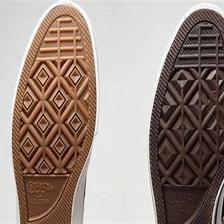

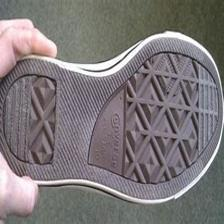

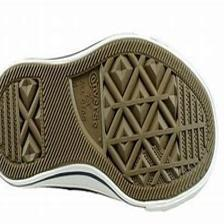

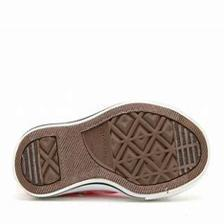

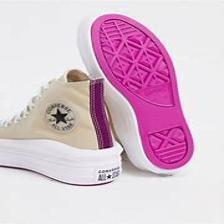

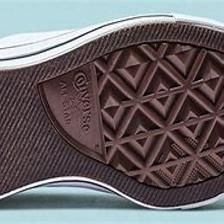

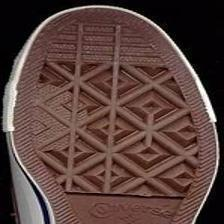

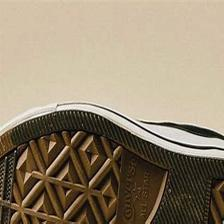

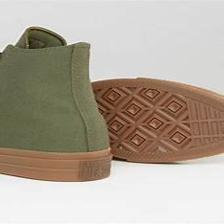

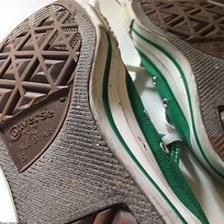

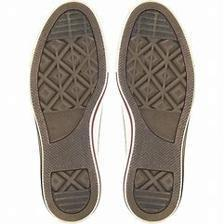

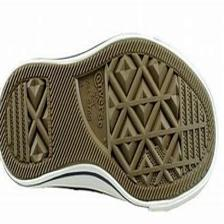

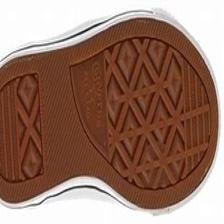

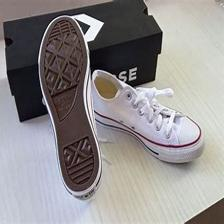

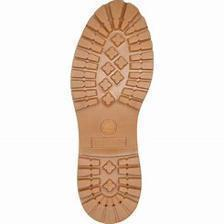

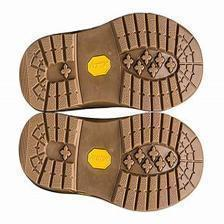

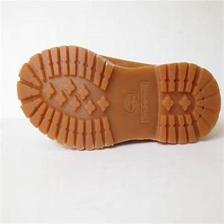

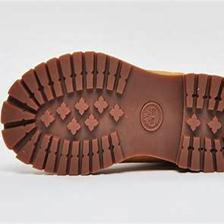

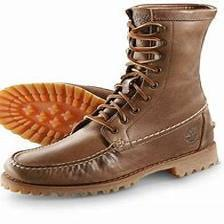

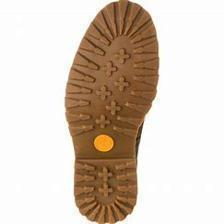

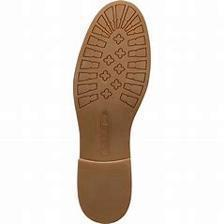

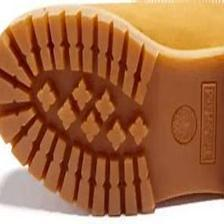

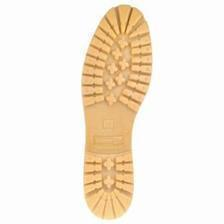

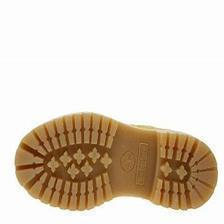

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.99215686, 0.99215686, 0.99215686],
        [0.99215686, 0.99215686, 0.99215686],
        [0.99215686, 0.99215686, 0.99215686],
        ...,
        [0.99215686, 0.99215686, 0.99215686],
        [0.99215686, 0.99215686, 0.99215686],
        [0.99215686, 0.99215686, 0.99215686]],

       [[0.99215686, 0.99215686, 0.99215686],
        [0.99215686, 0.99215686, 0.99215686],
        [0.99215686, 0.99215686, 0.99215686],
        ...,
        [0.99215686, 0.99215686, 0.99215686],
        [0.99215686, 0.99215686, 0.99215686],
        [0.99215686, 0.99215686, 0.99215686]],

       [[0.99215686, 0.99215686, 0.99215686],
        [0.99215686, 0.99215686, 0.99215686],
        [0.99215686, 0.99215686, 0.99215686],
        ...,
        [0.99215686, 0.99215686, 0.99215686],
        [0.99215686, 0.99215686, 0.99215686],
        [0.99215686, 0.99215686, 0.99215686]],

       ...,

       [[0.99215686, 0.99215686, 0.99215686],
        [0.99

In [2]:
def resize_image(image_paths) :

    for i,image_paths in enumerate(image_paths) :
        image = Image.open(image_paths)
        size = (224,224)
        image = image.resize(size)
        image.save(image_paths)
        image.show()
        image = tf.io.read_file(image_paths) ## remove the initial filepath for future use
        image = tf.image.decode_image(image,channels=3)
        image = tf.cast(image,tf.float32)
        image = image/255.0

    return image

data = pd.read_csv('/lakehouse/default/Files/shoe_details.csv')
resize_image('/lakehouse/default/Files/' + data['image_path'])

# Functions to Augment Dataset

In [3]:

def transform_image(imagePath,i,j,brand) :
    angles = np.linspace(5,350,5)
    for k,angle in enumerate(angles) :
        print(angle)
        image = Image.open(imagePath)
        rotate_image = image.rotate(angle)
        flipped_image = rotate_image.transpose(Image.FLIP_LEFT_RIGHT)
        image_name = '/lakehouse/default/Files/' + brand + '_shoe_data/' + brand + '_shoe_flip_'+ str(k) +'.jpg'
        flipped_image.save(image_name)
        data.append({'brand': brand, 'image_name': image_name})
    return data

def adjust_brightness(imagePath,i,j,brand,model,price,sizes,data):
    factors = np.linspace(1,1.9,5)
    for k,factor in enumerate(factors):
        image = Image.open(imagePath)
        enhancer = ImageEnhance.Brightness(image)
        adjusted_image = enhancer.enhance(factor)
        image_name = '/lakehouse/default/Files/' + brand + '_shoe_data/' + brand + '_shoe_adjust_'+ str(k) +'.jpg'
        adjusted_image.save(image_name)
        data.append({'brand': brand, 'image_name': image_name})
    return data


StatementMeta(, 4c726f5e-5abc-4204-88f5-f67b8b3bc843, 5, Finished, Available)

# Create Test and Train Datasets

In [4]:
data = pd.read_csv("/lakehouse/default/" + "Files/shoe_details.csv")
# split data into features and labels and encode labels


def split_test_train(features,labels):

    X = features
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)
    y = labels

    label_mapping = dict(zip(label_encoder.classes_,label_encoder.transform(label_encoder.classes_)))
    df_label_mapping = pd.DataFrame(list(label_mapping.items()),columns=['Category','Value'])
    df_label_mapping.to_csv('/lakehouse/default/Files/mapping.csv', index=False)

    # split data into training and testing

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

    return X_train,X_test,y_train,y_test

def load_and_preprocess_image(image_path, label):

    image = tf.io.read_file(image_path) ## remove the initial filepath for future use
    image = tf.image.decode_image(image,channels=3)
    image = tf.cast(image,tf.float32)
    image = image/255.0

    return(image,label)
    
def df_to_dataset(features,labels, batch_size=5) :

    IMG_HEIGHT,IMG_WIDTH = 224,224

    # map labels to numerical values

    dataset = tf.data.Dataset.from_tensor_slices((features,labels))
    dataset = dataset.map(lambda x,y: load_and_preprocess_image(x,y))

    #batch and shuffle the dataset
    shuffle_buffer_size = len(labels)
    dataset = dataset.shuffle(shuffle_buffer_size).batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    for batch in dataset.take(1):
        images,labels = batch
        print(images.shape, labels.shape)

    return dataset
X_train,X_test,y_train,y_test = split_test_train('/lakehouse/default/Files/' + data['image_path'],data['brand'])

test_dataset = df_to_dataset(X_test,y_test)
train_dataset = df_to_dataset(X_train,y_train)


StatementMeta(, 4c726f5e-5abc-4204-88f5-f67b8b3bc843, 6, Finished, Available)

2024-06-06 12:38:21.127978: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [12]
	 [[{{node Placeholder/_1}}]]
2024-06-06 12:38:21.128372: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [12]
	 [[{{node Placeholder/_1}}]]
2024-06-06 12:38:21.567291: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [48]
	 [[{{n

(5, 224, 224, 3) (5,)
(5, 224, 224, 3) (5,)


# Train  Tensor Flow Model

In [5]:
mlflow.set_experiment("classify_shoes")
mlflow.tensorflow.autolog()
with mlflow.start_run() as run:

    tf_id = run.info.run_id
    #create the convolutional base

    model = models.Sequential()
    model.add(layers.Conv2D(32,(3,3), activation='relu', input_shape = (224, 224, 3)))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Conv2D(64,(3,3),activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Conv2D(64,(3,3),activation='relu'))

    #add dense layers on top

    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(4, activation='softmax'))

    model.compile(optimizer = 'adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics= ['accuracy'])
    epochs = 20
    history = model.fit(train_dataset,epochs=epochs, batch_size=5)
    
    # Evaluate the model

    test_loss, test_acc = model.evaluate(test_dataset, verbose = 2)

    print('\nTest accuracy:', test_acc)

    acc = history.history['accuracy']

    loss = history.history['loss']

StatementMeta(, 4c726f5e-5abc-4204-88f5-f67b8b3bc843, 7, Finished, Available)

2024-06-06 12:38:25.531962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [48]
	 [[{{node Placeholder/_0}}]]
2024-06-06 12:38:25.532209: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [48]
	 [[{{node Placeholder/_1}}]]
2024-06-06:12:38:25,588 WARNING  [tracking_store.py:153] log_inputs not supported
2024-06-06 12:38:45.797179: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a va

Epoch 1/20
10/10 [==============================] - 4s 200ms/step - loss: 5.2909 - accuracy: 0.3125
Epoch 2/20
10/10 [==============================] - 1s 64ms/step - loss: 1.3748 - accuracy: 0.3750
Epoch 3/20
10/10 [==============================] - 1s 63ms/step - loss: 1.3191 - accuracy: 0.3958
Epoch 4/20
10/10 [==============================] - 1s 64ms/step - loss: 1.2444 - accuracy: 0.3542
Epoch 5/20
10/10 [==============================] - 1s 65ms/step - loss: 1.0166 - accuracy: 0.5000
Epoch 6/20
10/10 [==============================] - 1s 63ms/step - loss: 0.7590 - accuracy: 0.7083

# Using Pre-trained Model

MobileNetV2

In [6]:
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation,RandomZoom
mlflow.set_experiment("classify_shoes")
mlflow.tensorflow.autolog()


with mlflow.start_run() as run:

    data_augmentation = tf.keras.Sequential([

        RandomFlip("horizontal",input_shape= (224,224,3)),
        RandomRotation(factor=0.4),
        RandomZoom(height_factor = 0.2,width_factor = 0.2),
        ])

    base_model = MobileNetV2(weights='imagenet',
                 include_top = False,
                 input_shape = (224,224,3))

    inputs = tf.keras.Input(shape=(224,224,3))

    x = data_augmentation(inputs)
    x = base_model(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)

    predictions = Dense(5, activation='softmax')(x)

    model = Model(inputs = inputs, outputs = predictions)

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    history = model.fit(train_dataset, epochs = 4,validation_data = test_dataset)

    test_loss, test_acc = model.evaluate(test_dataset, verbose = 2)

    print('\nTest accuracy:', test_acc)

    acc = history.history['accuracy']

    loss = history.history['loss']

StatementMeta(, 4c726f5e-5abc-4204-88f5-f67b8b3bc843, 8, Finished, Available)

9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/4
10/10 [==============================] - 5s 213ms/step - loss: 2.0523 - accuracy: 0.3958 - val_loss: 0.9336 - val_accuracy: 0.5833
Epoch 2/4
10/10 [==============================] - 1s 55ms/step - loss: 0.8123 - accuracy: 0.7917 - val_loss: 1.0883 - val_accuracy: 0.8333
Epoch 3/4
10/10 [==============================] - 1s 57ms/step - loss: 0.4486 - accuracy: 0.8750 - val_loss: 0.2820 - val_accuracy: 0.9167
Epoch 4/4
1/1 [==============================] - 1s 517ms/step
Found untraced functions such as _update_step_xla, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 53). These functions will not be directly callab

2024-06-06:12:39:07,2 WARNING  [tracking_store.py:153] log_inputs not supported
2024-06-06:12:39:07,30 WARNING  [tracking_store.py:153] log_inputs not supported
/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2024-06-06 12:39:15.271176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [48]
	 [[{{node Placeholder/_0}}]]
2024-06-06 12:39:15.271438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an err

# Create Prediction Dataset
(no labels)

StatementMeta(, 4c726f5e-5abc-4204-88f5-f67b8b3bc843, 9, Finished, Available)

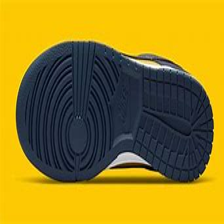

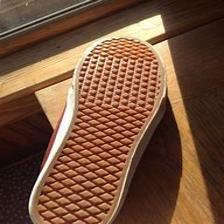

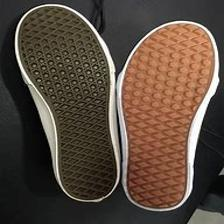

2024-06-06 12:40:08.810971: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [3]
	 [[{{node Placeholder/_0}}]]


In [7]:
import PIL
from PIL import Image
import numpy as np
import pandas as pd
def load_and_preprocess_image(image_path):

    image = tf.io.read_file('/lakehouse/default/Files/' + image_path) ## remove the initial filepath for future use
    image = tf.image.decode_image(image,channels=3)
    image = tf.cast(image,tf.float32)
    image = image/255.0

    return(image)
    
def df_to_dataset_predict(image_paths, batch_size=32) :

    IMG_HEIGHT,IMG_WIDTH = 224,224

    # map labels to numerical values

    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(lambda x :load_and_preprocess_image(x))

    #batch and shuffle the dataset
   
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    for batch in dataset.take(1):
        images = batch


    return dataset

data = pd.read_csv('/lakehouse/default/Files/predict.csv')

def resize_image(image_paths) :

    for i,image_paths in enumerate(image_paths) :
        image = Image.open(image_paths)
        size = (224,224)
        image = image.resize(size)
        image.save(image_paths)
        image.show()

    return image

data = pd.read_csv('/lakehouse/default/Files/predict.csv')
resize_image('/lakehouse/default/Files/' + data['image_path'])

dataset_predict = df_to_dataset_predict(data['image_path'])



In [15]:


import pandas as pd
# Load data into pandas DataFrame from "/lakehouse/default/" + "Files/predict.csv"
df = pd.read_csv("/lakehouse/default/" + "Files/predict.csv")
display(df['image_path'])



StatementMeta(, 715eef40-b3c6-4fe3-90e2-029986b3d140, 17, Finished, Available)

0    predict/1.jpg
1    predict/2.jpg
2    predict/3.jpg
Name: image_path, dtype: object

# Predict

In [8]:
from PIL import Image

prediction = model.predict(dataset_predict)
class_labels = np.argmax(prediction,axis = 1)
df = spark.read.format("csv").option("header","true").load("Files/mapping.csv")


print(class_labels)


StatementMeta(, 4c726f5e-5abc-4204-88f5-f67b8b3bc843, 10, Finished, Available)

2024-06-06 12:40:17.477390: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [3]
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 1s 570ms/step
[1 3 3]


# Show Predictions

StatementMeta(, 4c726f5e-5abc-4204-88f5-f67b8b3bc843, 11, Finished, Available)

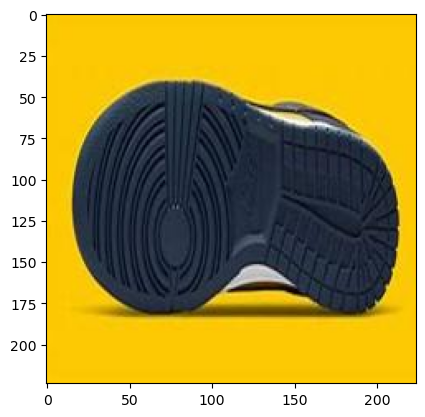

Predicted Class Labels: ['nike'] Probability: [0.9999672]


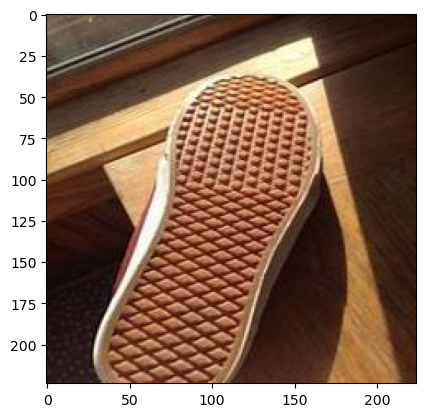

Predicted Class Labels: ['vans'] Probability: [0.9998652]


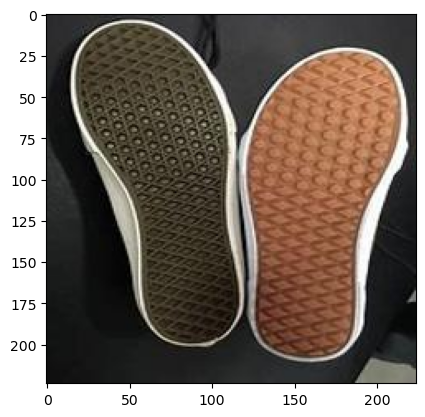

Predicted Class Labels: ['vans'] Probability: [0.9986216]


In [9]:
for i,value in enumerate(class_labels):
        predicted_labels =[]
        prediction_probabilities = []
        image = []
        original_image_path = []
        class_label = df.filter(df['Value'] == value).select('Category').collect()[0][0]
        predicted_labels.append(class_label)
        prediction_probabilities.append(prediction[i][value])
        image_path = data['image_path'].iloc[i]
        image_path = Image.open('/lakehouse/default/Files/' + image_path)
        image_array = np.array(image_path)
        image.append(image_array)

        plt.imshow(image_array)
        plt.show()

        print("Predicted Class Labels:", predicted_labels,"Probability:",prediction_probabilities)


